In [22]:
# %%
from utils import *
from crosscoder import CrossCoder as crossCoder
torch.set_grad_enabled(False);

In [23]:
# Pythia19m 30vs60 checkpoint crosscoder
# repo_id: str = "victiny1223/crosscoder-checkpoints"
# currently hardcoded. need to change later.

In [24]:
# %%
repo_id = "victiny1223/crosscoder-checkpoints"

cross_coder = crossCoder.load_from_hf()

checkpoints/version_15/2_cfg.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

2.pt:   0%|          | 0.00/537M [00:00<?, ?B/s]

/home/ubuntu/crosscoders/crosscoder-model-diff-replication/crosscoder.py:201: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [25]:
# %%
norms = cross_coder.W_dec.norm(dim=-1)
norms.shape
# %%

torch.Size([16384, 2])

In [26]:
relative_norms = norms[:, 1] / norms.sum(dim=-1)
relative_norms.shape

torch.Size([16384])

# Graphing latents norm distribution and cosine similarities

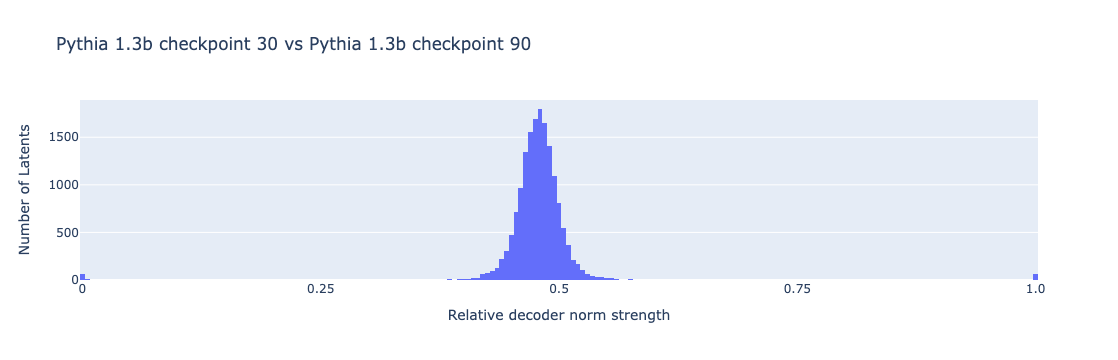

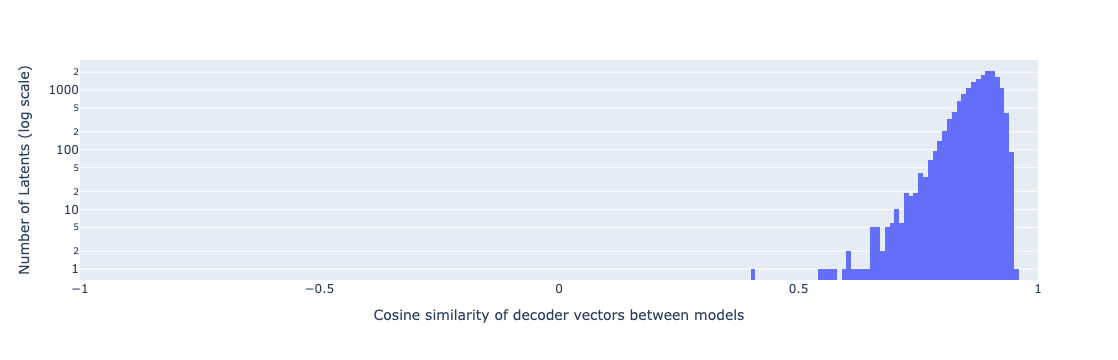

In [27]:

# %%

fig = px.histogram(
    relative_norms.detach().cpu().numpy(), 
    title="Pythia 1.3b checkpoint 30 vs Pythia 1.3b checkpoint 90",
    labels={"value": "Relative decoder norm strength"},
    nbins=200,
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents")

# Update x-axis ticks
fig.update_xaxes(
    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
    ticktext=['0', '0.25', '0.5', '0.75', '1.0']
)

# Display in notebook
fig.show()

# %%
shared_latent_mask = (relative_norms < 0.7) & (relative_norms > 0.3)
shared_latent_mask.shape
# %%
# Cosine similarity of recoder vectors between models

cosine_sims = (cross_coder.W_dec[:, 0, :] * cross_coder.W_dec[:, 1, :]).sum(dim=-1) / (cross_coder.W_dec[:, 0, :].norm(dim=-1) * cross_coder.W_dec[:, 1, :].norm(dim=-1))
cosine_sims.shape
# %%

fig = px.histogram(
    cosine_sims[shared_latent_mask].to(torch.float32).detach().cpu().numpy(), 
    log_y=True,  # Sets the y-axis to log scale
    range_x=[-1, 1],  # Sets the x-axis range from -1 to 1
    nbins=100,  # Adjust this value to change the number of bins
    labels={"value": "Cosine similarity of decoder vectors between models"}
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents (log scale)")

# Display in notebook
fig.show()

# %%

# Analyse the unique latents

## Maximum activating examples
Get tokens that maximally activate latent_idx
- Run a bunch of tokens, collect activations and probably cache these
- Run activations through encode in batches

In [9]:
def get_max_activating_tokens(cross_coder, model_A, model_B, tokens, latent_idx, top_k=10):
    """
    tokens: input tokens to analyze [batch, seq_len]
    latent_idx: which latent dimension to analyze
    """
    with torch.no_grad():
        # Get activations from both models
        _, cache_A = model_A.run_with_cache(tokens, names_filter="blocks.18.hook_resid_pre")
        _, cache_B = model_B.run_with_cache(tokens, names_filter="blocks.18.hook_resid_pre")
        
        # Stack activations [2, batch, seq_len, d_model]
        acts = torch.stack([
            cache_A["blocks.18.hook_resid_pre"],   
            cache_B["blocks.18.hook_resid_pre"]
        ], dim=0)

        # print(acts.shape)
        
        # Reshape to [batch*seq_len, 2, d_model]
        acts = einops.rearrange(acts, 
            "n_models batch seq_len d_model -> (batch seq_len) n_models d_model")
        
        # Get encoded activations
        encoded = cross_coder.encode(acts)  # [(batch*seq_len), d_hidden]
        
        # Get activations for specific latent
        latent_acts = encoded[:, latent_idx]
        
        # Find top activating positions
        top_values, top_indices = latent_acts.topk(top_k)
        
        # Map top_indices back to batch and sequence indices
        batch_size, seq_len = tokens.shape
        token_indices = top_indices % (batch_size * seq_len)
        batch_indices = token_indices // seq_len
        seq_indices = token_indices % seq_len
        
        return batch_indices, seq_indices, top_values

# Load in models

In [28]:
device = 'cuda:0'

N_1 = 30
pythia1 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_1, device = device)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model pythia-1.3b into HookedTransformer


In [29]:
# pythia1.blocks

In [30]:
N_2 = 90
pythia2 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_2, device = device) # commented out due to too much memory

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model pythia-1.3b into HookedTransformer


# loading in tokens

In [31]:
from utils import load_pile_deduped_pythia_random_sampled
test_tokens = load_pile_deduped_pythia_random_sampled().reshape((-1, 1024))

Loading data from disk


/home/ubuntu/crosscoders/crosscoder-model-diff-replication/utils.py:184: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Analysis attempt 1

### Finding the norm scaling factors for both Pythia 1.3b 30 and 90

In [10]:
import numpy as np
import tqdm
def estimate_norm_scaling_factor(test_tokens, batch_size, model, n_batches_for_norm_estimate=4, hook_point=None):

    print("=== Debug Info ===")
    print(f"Tokens shape: {test_tokens.shape}")
    print(f"Batch size: {batch_size}")
    print(f"Model context length: {model.cfg.n_ctx}")
    print(f"Model d_model: {model.cfg.d_model}")

    norms_per_batch = []
    for i in tqdm.tqdm(
        range(n_batches_for_norm_estimate), desc="Estimating norm scaling factor"
    ):
        tokens = test_tokens[i * batch_size: (i + 1) * batch_size]
        _, cache = model.run_with_cache(
            tokens,
            names_filter=hook_point,
            return_type=None,
        )
        acts = cache[hook_point]
        # TODO: maybe drop BOS here
        norms_per_batch.append(acts.norm(dim=-1).mean().item())
    mean_norm = np.mean(norms_per_batch)
    scaling_factor = np.sqrt(model.cfg.d_model) / mean_norm

    return scaling_factor

In [11]:
ch30_scaling_factor = estimate_norm_scaling_factor(test_tokens, 16, pythia1, hook_point = cross_coder.cfg["hook_point"])

=== Debug Info ===
Tokens shape: torch.Size([64, 1024])
Batch size: 16
Model context length: 2048
Model d_model: 2048



stimating norm scaling factor: 100%|███████████████████████████████████| 4/4 [00:11<00:00,  3.00s/it]

In [12]:
ch30_scaling_factor

0.2678755515310653

In [13]:
ch90_scaling_factor = estimate_norm_scaling_factor(test_tokens, 16, pythia2, hook_point = cross_coder.cfg["hook_point"])

=== Debug Info ===
Tokens shape: torch.Size([64, 1024])
Batch size: 16
Model context length: 2048
Model d_model: 2048



stimating norm scaling factor: 100%|███████████████████████████████████| 4/4 [00:11<00:00,  2.97s/it]

In [14]:
ch90_scaling_factor

0.2685573000064188

In [15]:
def fold_activation_scaling_factor(cross_coder, base_scaling_factor, chat_scaling_factor):
    cross_coder.W_enc.data[0, :, :] = cross_coder.W_enc.data[0, :, :] * base_scaling_factor
    cross_coder.W_enc.data[1, :, :] = cross_coder.W_enc.data[1, :, :] * chat_scaling_factor

    # cross_coder.W_dec.data[:, 0, :] = cross_coder.W_dec.data[:, 0, :] / base_scaling_factor
    # cross_coder.W_dec.data[:, 1, :] = cross_coder.W_dec.data[:, 1, :] / chat_scaling_factor

    # cross_coder.b_dec.data[0, :] = cross_coder.b_dec.data[0, :] / base_scaling_factor
    # cross_coder.b_dec.data[1, :] = cross_coder.b_dec.data[1, :] / chat_scaling_factor
    return cross_coder

In [17]:
cross_coder = fold_activation_scaling_factor(cross_coder, ch30_scaling_factor, ch90_scaling_factor)

## Printing tokens and whatever functions

In [29]:
def print_token_in_context(tokens, batch_idx, seq_idx, window_size=10, model=pythia2):
    """
    Print a window of tokens around a specific token, showing maximum available context
    """
    # Get start and end indices, bounded by sequence length
    start = max(0, seq_idx - window_size)
    end = min(tokens.shape[1], seq_idx + window_size + 1)
    
    # Get the context window and target token
    context = tokens[batch_idx, start:end]
    target_token = tokens[batch_idx, seq_idx]
    
    # Get the strings
    text = model.to_string(context)
    token_str = model.to_string(target_token)
    
    # Replace whitespace with visible characters for display
    token_display = token_str.replace(' ', '␣').replace('\n', '⏎').replace('\t', '⇥')

    # Print with color
    colors = {
        'red': '\033[91m',
        'blue': '\033[94m',
        'ENDC': '\033[0m'
    }
    
    # For debugging
    print(f"{colors['blue']}Token: '{token_display}'{colors['ENDC']}")
    
    # Split into individual tokens and find the target token position
    context_tokens = [model.to_string(t) for t in context]
    relative_pos = seq_idx - start
    
    # Calculate string positions
    start_pos = sum(len(t) for t in context_tokens[:relative_pos])
    token_len = len(context_tokens[relative_pos])
    
    print(text[:start_pos] + 
          colors['red'] + text[start_pos:start_pos+token_len] + colors['ENDC'] + 
          text[start_pos+token_len:])

def analyse_max_act_tok_batched(latent_idx, batch_size=32, topk=10):
    print("-" * 50)
    print("LatentIDX:", latent_idx.item())
    
    # Lists to store results from each batch
    all_batch_indices = []
    all_seq_indices = []
    all_values = []
    
    # Process in batches
    for i in tqdm(range(0, len(test_tokens), batch_size)):
        batch_tokens = test_tokens[i:i+batch_size].to(device)
        
        # Get top k for this batch
        batch_indices, seq_indices, values = get_max_activating_tokens(
            cross_coder, pythia1, pythia2, batch_tokens, latent_idx, top_k=topk
        )
        
        # Adjust batch indices to global indices
        batch_indices = batch_indices + i
        
        # Store results
        all_batch_indices.extend(batch_indices.cpu())
        all_seq_indices.extend(seq_indices.cpu())
        all_values.extend(values.cpu())
    
    # Convert to tensors
    all_batch_indices = torch.tensor(all_batch_indices)
    all_seq_indices = torch.tensor(all_seq_indices)
    all_values = torch.tensor(all_values)
    
    # Get overall top 10
    top_k = 10
    top_indices = torch.topk(all_values, min(top_k, len(all_values)))
    final_batch_indices = all_batch_indices[top_indices.indices]
    final_seq_indices = all_seq_indices[top_indices.indices]
    
    print("\nTop activating contexts:")
    print("-" * 50)
    for i, (batch_idx, seq_idx) in enumerate(zip(final_batch_indices, final_seq_indices)):
        print(f"\n{i+1}. Value: {top_indices.values[i]:.3f}")
        print_token_in_context(test_tokens, batch_idx, seq_idx, window_size=10, model=pythia2)
    
    # Clean up memory
    torch.cuda.empty_cache()
    
    return final_batch_indices, final_seq_indices, top_indices.values

## Let's take a look at latents mostly unique to Pythia 1.3b checkpoint 90...

In [30]:
torch.cuda.empty_cache()
import gc
gc.collect()

1431

In [32]:
from tqdm import tqdm

In [33]:
mask = relative_norms > 0.9975
indices_0 = mask.nonzero().squeeze()[:4]
for latent_idx in indices_0:
    analyse_max_act_tok_batched(latent_idx, batch_size = 16)

--------------------------------------------------
LatentIDX: 52



00%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.42s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 5.715
Token: '␣old'
 had a mRS score of 4 (due to old age), and one had a mRS score of

2. Value: 5.430
Token: 'Get'
InfoCommandCode;
extern const char *gtGetSystemInfoResponseCode;
extern const char *

3. Value: 5.299
Token: '␣controlled'
 dark, slender hands, the nails conduct a randomized controlled trial in 406 participants to evaluate the effects on weight

4. Value: 5.130
Token: '␣University'
 Morgan and Anthony Reid (Cambridge, UK: Cambridge University Press, 2010), 402.

[39

5. Value: 5.125
Token: '␣and'
 in space technologies. GISTDA cooperation with Japan and France is in full swing. A lot of mutually

6. Value: 5.043
Token: '.'
L7By: ArtL7http://www.metafilter.com/124281/I--

7. Value: 5.035
Token: '␣M'
 building
about my mistake, adding my plea to Mme. Harmonie pretense of hope,

8. Value: 4.944
Token: '␣Mer'
 after Merlin wrappped the actor who played Merlin was also in some other show


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.47s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 4.978
Token: '␣but'
 anything for that." "What about your wife? but after I left her..." "I realized what a

2. Value: 4.256
Token: '␣Instead'
 of money but at what cost to my soul? Instead, I nobly pursue something purer than wealth

3. Value: 4.215
Token: '␣thought'
's App. at 1-2, 22 I thought of is to loop through the initial Query Object and

4. Value: 4.041
Token: '␣But'
 is leaving home, albeit as a freed slave. But then he loses his mentor, Qui-G

5. Value: 4.037
Token: '␣Finally'
inh had become murderous. . . . Finally, we learned that Hinh was close to

6. Value: 3.961
Token: 'if'
 in the same area.
 know anymore..." "if it's sympathy or not." "I'm not

7. Value: 3.802
Token: 'Then'
 side, that's No Chris grins

Then cup your hand and place it on top of your

8. Value: 3.698
Token: ','
 money but at what cost to my soul? Instead, I nobly pursue something purer than wealth:

9. Value: 3.684


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.50s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.710
Token: ''s'
سة نعم was a vision of Africa's future. And before city governor Babatunde F

2. Value: 3.284
Token: '␣of'
ترسة نعم was a vision of Africa's future. And before city governor Babat

3. Value: 3.258
Token: '␣a'
 المفترسة نعم was a vision of Africa's future. And before city governor

4. Value: 3.129
Token: '␣notice'
 limitation of this study was asshole survival strategies fail to notice they’re part of the asshole contingent?


5. Value: 3.109
Token: '␣/*'

  1, /* quack */ 2, /* quack */3,
);

array

6. Value: 3.039
Token: '.'
achievement at school is costing £18 billion. Reoffending by prisoners, £11 billion.

7. Value: 2.921
Token: '␣And'
عم was a vision of Africa's future. And before city governor Babatunde Fashola took

8. Value: 2.812
Token: '␣pain'
 from the decree of  on Eve that "in pain you shall bring forth children."

Interpre

9. Value: 2.778
Token: '␣smashed'


Frodo to

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.50s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.902
Token: '_\'
1

[::::::::]  
*_\\_\\_\j\~  
&u

2. Value: 2.890
Token: 'N'
      H        OH       OH
  15    Nobiletin       OCH~3~   O

3. Value: 2.637
Token: 'Z'
 to be given the right of way.

Z

Zone of danger: the area within which

4. Value: 2.605
Token: '␣questions'
   
Fare thee well

Thou questions concerning defendant's infraction of prison rules sought to

5. Value: 2.398
Token: '*'
d1

[::::::::]  
*_\\_\\_\j\~  
&

6. Value: 2.388
Token: '␣Cambridge'

In this study, we analyzed specific health New Cambridge History of Islam, Volume 3: The Eastern Islamic

7. Value: 2.327
Token: '.'


I have to admit that this oneInd. Ct. App. 1993).

       Court of

8. Value: 2.298
Token: 'sigma'


$\sigma_i$ and $\sigma_{i+2

9. Value: 2.235
Token: '␣History'
In this study, we analyzed specific health New Cambridge History of Islam, Volume 3: The Eastern Islamic World

10. Value: 2.228
Token: 'S

In [19]:
# del all_encoded


In [34]:
# batch_size = 256
# all_encoded = []  # Store all encoded activations

# for i in tqdm(range(0, len(test_tokens), batch_size)):
#         batch_tokens = test_tokens[i:i+batch_size].to(device)
        
#         with torch.no_grad():
#             # Your existing code for running models and getting activations
#             _, cache_A = pythia1.run_with_cache(batch_tokens, names_filter="blocks.18.hook_resid_pre")
#             _, cache_B = pythia2.run_with_cache(batch_tokens, names_filter="blocks.18.hook_resid_pre")
            
#             acts = torch.stack([
#                 cache_A["blocks.18.hook_resid_pre"],   
#                 cache_B["blocks.18.hook_resid_pre"]
#             ], dim=0)
            
#             acts = einops.rearrange(acts, 
#                 "n_models batch seq_len d_model -> (batch seq_len) n_models d_model")
            
#             # Get encoded activations
#             encoded = cross_coder.encode(acts)
            
#             # Store batch encodings
#             all_encoded.append(encoded)

# # Concatenate all batches
# all_encoded = torch.cat(all_encoded, dim=0)  # [(total_batch*seq_len), d_hidden]

# # Now measure sparsity metrics
# threshold = 1e-5
# l0_sparsity = (all_encoded.abs() > threshold).float().mean() * 100
# l1_norm = all_encoded.abs().mean()
# dead_features = (~(all_encoded.abs() > threshold).any(dim=0)).sum()

# print(f"L0 Sparsity: {l0_sparsity:.2f}% features active")
# print(f"L1 Norm: {l1_norm:.3f}")
# print(f"Dead features: {dead_features}")

# # Plot distribution
# fig = plot_activation_histogram(all_encoded)
# fig.show()

In [25]:
def plot_activation_histogram_split(latents):
    flat_acts = latents.flatten().cpu().numpy()
    
    fig = go.Figure()
    
    # Positive activations
    fig.add_trace(go.Histogram(
        x=flat_acts[flat_acts >= 0],
        name='Positive',
        nbinsx=50,
        marker_color='blue'
    ))
    
    # Negative activations
    fig.add_trace(go.Histogram(
        x=flat_acts[flat_acts < 0],
        name='Negative',
        nbinsx=50,
        marker_color='red'
    ))
    
    fig.update_layout(
        barmode='overlay',
        title='Latent Activation Distribution',
        xaxis_title='Activation Value',
        yaxis_title='Count'
    )
    
    return fig

In [ ]:
# fig = plot_activation_histogram_split(all_encoded)
# fig.show()

## now what about those latents unique to Pythia 1.3b checkpoint 30?

In [35]:
mask = relative_norms < 0.01
indices_0 = mask.nonzero().squeeze()
for latent_idx in indices_0:
    analyse_max_act_tok_batched(latent_idx, batch_size = 16)

--------------------------------------------------
LatentIDX: 428



00%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.45s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.822
Token: '.'
 consent after reviewing the IRB-approved consent form. The study was performed under a waiver of documentation of

2. Value: 2.696
Token: '␣are'
 and staggering…

My wife and that i are now delighted that Albert could execute his scientific tests because

3. Value: 2.451
Token: '␣that'


My wife and that i are now delighted that Albert could execute his scientific tests because of the strategies

4. Value: 2.423
Token: 'ty'
 Tiger beer. Not wanting to screw up Smitty's deal before it Solutions." "Just don't

5. Value: 2.364
Token: 'eps'
, \qquad
\rho^\eps v^\eps\otimes v^\eps \wksto \rho

6. Value: 2.262
Token: 'ess'
 con window
<lippo> come se avessero bloccato il mio accoun


7. Value: 2.160
Token: '␣time'
70 (five terms in all). At the same time, he broadened his business operations in banking and

8. Value: 2.159
Token: ','
spatial-resolution sequences.Thursday, March 22, 2012



00%|███████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.49s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.678
Token: '␣seeking'
 In this whitepaper, a global publisher was seeking a partner that could mitigate risk and build a platform

2. Value: 2.384
Token: '␣raising'
 Most podcasts are working oninas seeks reversal by raising several issues: (1) whether the jury instructions

3. Value: 2.184
Token: '␣reminiscent'
 represents faith, loyalty, and devotion, while also reminiscent of the sky, sea, and lakes of the

4. Value: 2.181
Token: '␣triplicate'
 passion. Each individual aliquot was immediately loaded in triplicate to dry white Lumitrac 600, High Binding

5. Value: 2.168
Token: '␣disclosed'
 on advice that Lot 247 did not need to be disclosed. He knew it needed to be disclosed, and

6. Value: 2.083
Token: '_'
_new(t_vu *x, t_glist *glist)$ uniformly, and

7. Value: 2.021
Token: '␣from'
 It may be mad," he warned, coming back from closing the door.

The thing advanced to

8. Value: 1.990
Token: 'i


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.52s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 7.142
Token: '\'
a\right|-\left|q_b\right|\right) \, .$$ In this last equation

2. Value: 6.495
Token: 'oted'
 from a microscopic state via a projection operation (denoted by the projection operator $\mathscr{P}$). The

3. Value: 6.398
Token: 'eq'
Since the l.h.s. of (\[eq:LindebergMtPAグラン�

4. Value: 6.112
Token: '␣char'
 *gtEchoResponseCode;
extern const char *gtEchoFailureCode

5. Value: 6.043
Token: '="'
46-bib-0151){ref-type="ref"}, and sepsis [152 and tops, none

6. Value: 5.577
Token: '1'
stam ($k = 3$), $\frac{1}{24} = 0.041\dot{

7. Value: 5.575
Token: 'True'
 Version("1.1")));
        assertTrue(version the trial; characterized defendant's truck driver

8. Value: 5.426
Token: ']'
[14];
    Mac->Addr[5] = Ip->v6.Addr[15

9. Value: 5.131
Token: ']'
[13];
    Mac->Addr[4] = Ip->v6.Addr[14

10. Value: 4.980
Token: '1'
_x u_x) + \frac{1}{2} (\partial_3) < 0
-------------------------------------


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.52s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.365
Token: '␣in'
.” And with this injunction, turn to the strangers in your midst and you, too, will be brought

2. Value: 3.070
Token: ','
 g_{00} $ isBefore ERVIN, Chief Judge, and PHILLIPS and WIL

3. Value: 3.008
Token: '␣your'
 And with this injunction, turn to the strangers in your midst and you, too, will be brought closer

4. Value: 2.862
Token: 'Before'


where $ g_{00} $ isBefore ERVIN, Chief Judge, and PHILL

5. Value: 2.840
Token: '␣and'
 $ isBefore ERVIN, Chief Judge, and PHILLIPS and WILKINSON,

6. Value: 2.371
Token: '␣previous'
 the first first trillion digits were already known from the previous record, that comes out to approximately 4.5

7. Value: 2.200
Token: '␣the'
ons and a poached egg). Save room for the fruit tarts. And don't attempt Le B

8. Value: 2.130
Token: '␣in'
_7}
----------------------------------------

Although phosphodies in veneration of Baal, the Adon.

9. Val


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.53s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 4.348
Token: '-'
uka-itoh-1-xv771-haruka-itoh-likes-f

2. Value: 4.206
Token: '-'
                   prepost-msds      PWB-PR                      Kindness--Different 9, 9/

3. Value: 4.078
Token: '_-'
            if (request.command ==> Joker_-_: but there are several options
<abhi

4. Value: 4.031
Token: '-'
6234/haruka-itoh-1-xv771-haruka-itoh-

5. Value: 3.538
Token: '␣and'
 37°C. MIC determinations for the PA14 and ΔPA3225 strains were performed five times.

6. Value: 3.526
Token: '_'
 Beauty* transposon system is currently approved001_Table 1

###### 

Pharmaceutical

7. Value: 3.494
Token: ':'
 and 2 unaffected individuals. The proband (II:1), a 44-year-old male,

8. Value: 3.441
Token: '␣+'
 The reverse legend, on the other hand, reads + S '• CE RBON', with the letter

9. Value: 3.342
Token: '-'
 __index = request_index }+00	-1.549560E+01
+

10. Value: 3.294
Token: '_'
/sensors/temperature/p


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.53s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.462
Token: '␣Rect'
 ("Okay"))//(GUI.Button(new Rect((Screen.width/4)-30, (

2. Value: 2.450
Token: 'opian'
 ashes of the old one.

Cornucopian See boomer.

Declinism The

3. Value: 2.369
Token: '␣printed'
 and computer components of these systems are typically disposed on printed circuit boards. In order to protect the printed circuit

4. Value: 2.310
Token: '␣sin'
os en Madrid para ayudar a las personas sintecho" porque, en realidad, "

5. Value: 2.284
Token: '32'
f
	(p8) LDFD f32 = [AO1], SIZE
	(p

6. Value: 2.217
Token: 'com'
 11:48:03.162: INFO/com.thisclicks.appdataroom(

7. Value: 2.161
Token: '␣cheese'
 has combined the fish with Neufchâtel cheese—high in calcium and lower in calories than cream

8. Value: 2.144
Token: 'Write'
bool, bool>;
#[doc = "Write proxy for field `GCLK_`"]


9. Value: 2.081
Token: '␣np'
"a": [1, 2, 4, np.nan]}, index=exp_index)

10. Value: 2.032
Token: '␣socks'
 TIOC


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 7.563
Token: '␣con'
 red de corrupción De la entrevista con el vendedor de armamento del barrio

2. Value: 7.426
Token: '␣resident'
 a Sears Card issued in the name of a California resident  and found in Wilson's wallet when he was

3. Value: 7.069
Token: ':'
 platforms.

Previous attendees of this course include: Air Selangor, Alphamatic,

4. Value: 6.973
Token: '␣include'
 media platforms.

Previous attendees of this course include: Air Selangor, Alphamatic

5. Value: 6.911
Token: 'English'
 '67 and debonair all-too-English outfits of the eighties like The Monochrome

6. Value: 6.749
Token: ','
 of Claim.
EPA's own outside consultant, Henke, indirectly contradicted Hanzel,

7. Value: 6.654
Token: '␣said'
 “most difficult and complex failure” in its history said SpaceX CEO and Founder Elon Musk in

8. Value: 5.735
Token: 'air'
 could between Syd Barrett in '67 and debonair all-too-English outfits o


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 4.085
Token: '␣now'
 staggering…

My wife and that i are now delighted that Albert could execute his scientific tests because of

2. Value: 2.895
Token: '␣full'
But! Make no mistake about it, only a full-fledged move of God will suffice.

3. Value: 2.821
Token: '␣are'
 and staggering…

My wife and that i are now delighted that Albert could execute his scientific tests because

4. Value: 2.601
Token: '';'
elabs.com:80/wd/hub';

//seleniumUrl = "http://

5. Value: 2.526
Token: '␣a'

But! Make no mistake about it, only a full-fledged move of God will suffice

6. Value: 2.520
Token: '␣feet'
 the tops of their heads and a couple of bare feet. As I got closer, I saw that the

7. Value: 2.507
Token: 'ged'
 mistake about it, only a full-fledged move of God will suffice. This nation must make

8. Value: 2.447
Token: '),'
 (B) Cell counts of double negative (DN), double positive (DP), CD4 single positive and



00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 4.361
Token: '.'
Like the meal, living in commune is like that. The more you try new stuff, the better it

2. Value: 3.836
Token: '␣father'
 pursuing "growth at any cost," mother, her father had never changed her diapers.
One evening

3. Value: 3.747
Token: 'ens'
.29 mg/ml buffer solution). Specimens were then washed and mounted for analysis. Brightfield

4. Value: 3.596
Token: 'ml'
Sigma- Aldrich, 0.29 mg/ml buffer solution). Specimens were then washed and

5. Value: 3.589
Token: '␣The'
 the meal, living in commune is like that. The more you try new stuff, the better it gets

6. Value: 3.428
Token: '.'
 more you try new stuff, the better it gets.Q:

O que significam as ret

7. Value: 3.348
Token: ','
 is like that. The more you try new stuff, the better it gets.Q:

O

8. Value: 3.268
Token: '.'
 mother, her father had never changed her diapers.
One evening, her mother returned from a trip

9. Value


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.758
Token: 'ant'
, de sorte que, en bâtissant la maison, on n'entendît

2. Value: 2.419
Token: '):'
 Series) (Class 1) (4yo+): A fascinating 16-strong field including nine rivals rated

3. Value: 2.400
Token: '␣said'


"You have a nice place here," said Steven.

"Yes it's lovely,"

4. Value: 2.029
Token: '.'
ore a blue sweater with the letters P. H. on the breast.


REUTERS/

5. Value: 2.010
Token: '␣NL'
4-3 by site-directed mutagenesis to produce NL4-3 PR~I54V+V

6. Value: 1.901
Token: '␣and'
 protected]) is a former White House national security intern and Iraq War veteran. Follow him on Twitter @Matthew

7. Value: 1.892
Token: '⏎'
MatthewFecteau* Press release…

Criminal defendants who kill LGBTQ people can no

8. Value: 1.861
Token: '␣including'
 scored in the Lightning’s last two home games including two game-winning goals. He scored the game

9. Value: 1.850
Token: '␣including'
4yo+): A fasc


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.858
Token: 'TL'
 affected BMW Team RLL and the M6 GTLM more than other cars within the stacked GT Le

2. Value: 2.831
Token: '␣release'
o wasted any opportunity in driving agents partially prevent calcium release from a platelet subcellular organelle. Vitamin E quin

3. Value: 2.818
Token: '+'
7. We interpret these findings as showing that HS+saline induces catabolism with predominant fat oxidation for

4. Value: 2.694
Token: 'M'
 BMW Team RLL and the M6 GTLM more than other cars within the stacked GT Le Mans

5. Value: 2.682
Token: '␣correlation'
 In addition, granulysin levels exhibited a negative correlation with HBA1c and fasting blood glucose,

6. Value: 2.675
Token: 'aline'
 We interpret these findings as showing that HS+saline induces catabolism with predominant fat oxidation for energy generation

7. Value: 2.479
Token: '␣systems'
The literature data indicate the usefulness of several comm


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.820
Token: '␣urinary'
2(**argsate into free subunits greatly complicating urinary measurements. Antibodies specific for hLH beta core

2. Value: 2.015
Token: ','
 compare cord blood and age 5 year he left her, she borrowed small sums from her brother, who finally

3. Value: 1.978
Token: '␣K'
ptosis, and ferroptosis, in K7M2 osteosarcoma cells, which are due

4. Value: 1.919
Token: 'id'
N, same treatment pattern as IH most timid, reserved expression of approval from Netti sets your

5. Value: 1.886
Token: '�'
貼り付けた捕食動

Get timely insider information that you can

6. Value: 1.877
Token: '.'
 to admit that this oneInd. Ct. App. 1993).

       Court of Appeals of Indiana |

7. Value: 1.849
Token: '␣system'
 but an utter loss of taste and faculty for all system and for all philosophy. Like echoes that beget

8. Value: 1.759
Token: '␣show'
 abc 3 viwers as its an adult horror show, but its cool that all


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.595
Token: '␣create'

As mentioned above, the intent was not to create any DSLs, large dependencies, or any unnecessary

2. Value: 3.257
Token: '␣the'

A Simple API

As mentioned above, the intent was not to create any DSLs, large

3. Value: 3.126
Token: '␣the'
, or any unnecessary utilities. As a result, the API is tiny. To start a cluster, you

4. Value: 2.534
Token: '␣want'
 chrome is installed?
Note that I don't want execute chrome browser I want to embed it inside of

5. Value: 2.534
Token: '␣to'


As mentioned above, the intent was not to create any DSLs, large dependencies, or any

6. Value: 2.471
Token: '␣or'
 not to create any DSLs, large dependencies, or any unnecessary utilities. As a result, the API

7. Value: 2.429
Token: '␣for'
        except: pass

# TODO: API for Python miner (functional equivalent to XMRig

8. Value: 2.410
Token: ''t'

However, while this is convenient, you should


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.54s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.841
Token: '␣for'
 user memory graph instead of a pre-defined set for the model.

Experiments {#sec:

2. Value: 2.815
Token: '␣not'
ential damages, so the above limitation or exclusion may not apply to you.

4. This W

3. Value: 2.573
Token: '␣of'
 but there’s no reason the entire ammunition load of 1150

4. Value: 2.446
Token: '␣modern'
 a reasonable person would not consider contemporary to what is modernly available. 

…not considered contemporary to

5. Value: 2.416
Token: '␣testing'
 4 years old withmp 0.8 from Debian testing" [Wishlist,Fix released]


6. Value: 2.407
Token: '␣the'
 memory graph instead of a pre-defined set for the model.

Experiments {#sec:exp

7. Value: 2.194
Token: '␣and'
 mitigate risk and build a platform flexible enough rapid development and *Dynamic Recoveries* were crucial in creating

8. Value: 2.034
Token: 'ic'
 way, you have young people who are nostalgic for thing


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 77.269
Token: '.'
 with the principal Notan Lal for scolding him. Since he had not memorised his lesson, the

2. Value: 76.698
Token: '.'
 she wants us to believe have been her enduring cause. Few people know that it took until the spring of

3. Value: 74.267
Token: '.'
 each interpretation leads to a different result. The distant relationship in question and the purpose of the

4. Value: 74.210
Token: '.'
 the practical applicability of the quantitative-grammar approaches. We will build our framework of quantitative CLP on

5. Value: 74.149
Token: '.'
-2 mRNA induction by the Gal-lectin. Moreover, cells pretreated with an inhibitor of p38

6. Value: 73.377
Token: ']^.'
to-reach 'blind loop'^[@CR2]^. The bypassed ES, remains in the patient's

7. Value: 73.138
Token: '.'
 “Explore the Adventurous Life” this weekend. Enjoy.

10 Ideas To Awaken Your

8. Value: 72.931
Token: '.'
 been in place for resol


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 24.771
Token: '.'
 “Explore the Adventurous Life” this weekend. Enjoy.

10 Ideas To Awaken Your

2. Value: 24.724
Token: '.'
 gave the pharmacokinetic parameters of 0.083 hours (Tmax) reaching a Cmax

3. Value: 24.586
Token: '.'
-2 mRNA induction by the Gal-lectin. Moreover, cells pretreated with an inhibitor of p38

4. Value: 24.444
Token: '.'
 she wants us to believe have been her enduring cause. Few people know that it took until the spring of

5. Value: 24.247
Token: '.'
 with the principal Notan Lal for scolding him. Since he had not memorised his lesson, the

6. Value: 24.085
Token: ').'
 composer's student days (1816–1821). Carefully edited and bound in a handsome edition,

7. Value: 23.903
Token: '.'
 Newt didn't join in the applause that erupted.

'What's the matter, Newt

8. Value: 23.838
Token: '.'
 from beginning to end, making it ready for upload.

## The Sky's the Limit: Big

9. Value:


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.499
Token: '␣speculation'
 speculation make you feel?

It made me feel

2. Value: 3.252
Token: '␣marriage'
 marriage or other social issues, is generally unwarranted

3. Value: 3.099
Token: '␣variation'
 variation in disconnection rates by race and ethnicity, ranging

4. Value: 2.625
Token: '␣exact'
 exactness of the logic-programming approaches with the practical

5. Value: 2.593
Token: '␣this'
 this size (~750W) for 160 hours.

6. Value: 2.584
Token: '␣binary'
 binary system the integral simplifies to, $$h'_{

7. Value: 2.560
Token: '␣Metal'


Recording and production
As their EP Metal Circus was being released, Hüsker

8. Value: 2.402
Token: '␣extrem'
 in Norway is a sobering reminder that hate and extremism can drive people to commit unspeakable acts

9. Value: 2.370
Token: '␣like'
 body. You'll love looking at her wrapped up like a gift for your pleasure, but as she slowly

10. Value: 2.355
T


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 5.576
Token: '⏎'
 & Designs, LLC.

ADVERTISEMENT

Thanks for watching!]), identificaron la preval

2. Value: 4.596
Token: '⏎'
 2 - Jan 2016 (Current Generation)
]);
      }
    }
  }

  

3. Value: 4.524
Token: '⏎'
 bytes where we can store anything we want.

: Random-accessible arrayend{aligned}$$ with

4. Value: 4.225
Token: '⏎'

Blind Masseur 48 D1

Bliss Spa 48 E2

Bliss

5. Value: 4.198
Token: '⏎'
10-09-2013 01 70 D2

Blind Masseur 48 D1



6. Value: 4.174
Token: '⏎'
Tex Fandanglesburgerstein said.

“Oh, that. Sorry. Well when you

7. Value: 4.012
Token: '⏎'
 was in the wrong place,” Grant said.

“Fair enough. I can
*sms

8. Value: 3.996
Token: '⏎'
 stack can hold (i32, et al.)

and are like variables: named and can hold

9. Value: 3.839
Token: '⏎'
 can hold (i32, et al.)

and are like variables: named and can hold any

10. Value: 3.831
Token: '⏎'
es conifically for sorbitol intolerance:

• Con


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.373
Token: 'ating'

undefined
> 
RESULT: Deactivating TokenSeller Sell
undefined
> 

2. Value: 2.217
Token: 'ness'
-msds      PWB-PR                      Kindness--Different 9, 9/week             34       

3. Value: 2.110
Token: '␣of'
 So, were there any exception?

Yes of their last 10 games, scoring 29 goals and conced

4. Value: 2.110
Token: 'ult'
016)0.0150.007**Adult SES0.837 (0.689,

5. Value: 2.077
Token: ''s'
        assertTrue(version the trial; characterized defendant's truck driver as the client of plaintiff's attorney;

6. Value: 2.070
Token: '␣the'
  
$_\\_\\_\Z from the distant sea. A breath of freshness reached them

7. Value: 2.057
Token: '␣preventing'
 of board spacing, but each includes the disadvantage of preventing the worker or other person using the spacer from viewing

8. Value: 2.035
Token: '␣in'
 w = to the 20% that was already destroyed in the last 40 years. This makes C


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.336
Token: 'ped'
 all these actors got work after Merlin wrappped the actor who played Merlin was also in some

2. Value: 3.187
Token: '␣his'
 at leastner was offered this recuperation of his theory and chose not to accept it, insisting that

3. Value: 3.049
Token: '␣to'
 just better merge it with another right of center party to establish the Liberal Democratic Party (LDP) in

4. Value: 2.888
Token: '␣through'
 the top performer in each department:ded her back through the entryway.

She considered making a

5. Value: 2.874
Token: 'ING'
MISS MANAGEMENT
AND CODDLING OF
 weeks in addition to weekly group CBCST

6. Value: 2.850
Token: '␣at'
 attraction of the Mile Ex, slowly chipping away at its “industrial only” status.

A

7. Value: 2.791
Token: '␣to'
generated into mechanical drudgery, still adhered however to many of the principles and forms of ancient art.

8. Value: 2.683
Token: '␣on'
arts. And


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 7.946
Token: '/'
master/idcs-sdk-sample-apps/nodejs/README.md
The Oracle

2. Value: 7.793
Token: '="'
astParenPad"/>
        <module name="WhitespaceAfter"/>
        <module name

3. Value: 7.627
Token: '="'
="ParenPad"/>
        <module name="TypecastParenPad"/>
        <

4. Value: 7.411
Token: '/'
 GitHub documentation: https://github.com/oracle/idm-samples/blob/master/id

5. Value: 7.330
Token: '/'
cs-sdk-sample-apps/nodejs/README.md
The Oracle-by-

6. Value: 6.867
Token: '/'
oracle/idm-samples/blob/master/idcs-sdk-sample-apps/node

7. Value: 6.467
Token: '/'
https://github.com/carloscuesta/gitmojions of cigarettes for several bottles of

8. Value: 6.433
Token: '/'
"/xyz/openbmc_project/sensors/temperature/p0_core18_temp"

9. Value: 5.808
Token: '␣*'
gtEchoCommandCode;
extern const char *gtEchoResponseCode;
extern const char

10. Value: 5.681
Token: '}/'
" \
					-e "^${EROOT}/sbin/(ldconfig|sln


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 32.199
Token: '.'
 gave the pharmacokinetic parameters of 0.083 hours (Tmax) reaching a Cmax

2. Value: 30.550
Token: '.'
 “Explore the Adventurous Life” this weekend. Enjoy.

10 Ideas To Awaken Your

3. Value: 30.549
Token: '.'
 she wants us to believe have been her enduring cause. Few people know that it took until the spring of

4. Value: 30.534
Token: '.'
 have pointed out, too often such plans are ignored.

Jacobs, in fact, was a

5. Value: 30.479
Token: ').'
 composer's student days (1816–1821). Carefully edited and bound in a handsome edition,

6. Value: 30.349
Token: '.'
abank.m 10028 2017-08-11 16:

7. Value: 29.960
Token: '.'
 via RSA (or DSA) and logged in.

However, while this is convenient, you

8. Value: 29.900
Token: '.'
 to top-of-the-line market research. MRRSE’s repository is updated every day

9. Value: 29.859
Token: '.'
 Newt didn't join in the applause that erupted.

'What's the


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.563
Token: '95'
_index }+00	-1.549560E+01
+3.250000

2. Value: 2.551
Token: '25'
549560E+01
+3.250000E+00	+9.226160

3. Value: 2.528
Token: '54'
 request_index }+00	-1.549560E+01
+3.25

4. Value: 2.438
Token: '⏎'
w: &'a mut W,
}
impl<'a> GCLK__W<

5. Value: 2.412
Token: '16'
/6) prime?
False
Is (-16 - (-19)/1)*(- density is greater than

6. Value: 2.349
Token: '␣fet'
 right, right? And I think the numbers I fetched from the Census Bureau with just a couple of

7. Value: 2.314
Token: 'f'
Z* reporter integrated into the *pou4f1* locus, *Brn3a^

8. Value: 2.257
Token: '.'
	+9.4 and draw from personal experience. We’re pleased to see that this Summer School

9. Value: 2.239
Token: 'Discussion'
 p > 0.05 for both).

Discussion

The major objective of this study was to

10. Value: 2.161
Token: '⏎'
 false, 52));
    test.done();
}
Gold Motel‘s “Cold Should
------------------------------------------------


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.591
Token: '␣bus'
 Clara, Calif. In such computer systems, the bus architecture is optimized for burst performance. Generally, the

2. Value: 3.213
Token: '␣sun'
tolemy. Hipparchus knew that the sun takes about 94 1/2 days to move from

3. Value: 3.012
Token: '␣map'
 mapped container. This is usually a good thing. map on List will return List, map on Array will

4. Value: 2.985
Token: '␣foot'
 in architectural units. Consequently, you must enter the foot symbol to offset the property line 10′.


5. Value: 2.772
Token: '␣fork'
 for my gnome-applets customization? first fork gnome-applets------------

This three generation

6. Value: 2.599
Token: '␣object'
) simulations. This standard defines an interface, an object model and a set of rules in order to allow

7. Value: 2.493
Token: '␣value'
 4/18.
2
What is the value of ((-30)/(-25))/(104/(-65))?

8. Value: 2.418
Token: '␣system'

(8.69)

Actually, 


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 3.525
Token: '␣.'
  = f0
	}
	{ .m disappointing. Since the early 1980s the Brazilian

2. Value: 2.628
Token: ''s'
 plan, and Proof of Claim.
EPA's own outside consultant, Henke, indirectly contradicted

3. Value: 2.452
Token: 's'
  4         
 
“That’s what TV pundits do, isn’t

4. Value: 2.355
Token: 'm'
= f0
	}
	{ .m disappointing. Since the early 1980s the Brazilian growth

5. Value: 2.203
Token: '2'
    −8.13

  SiO~2~-TETA      9.42 ± 0

6. Value: 2.047
Token: '9'
  SiO~2~-TETA      9.42 ± 0.36    49.8

7. Value: 1.994
Token: 'ITC'
 generation and accumulation.

The effects of PEITC on the proliferative potential of K7M2 oste

8. Value: 1.957
Token: ']'
; and the best one/.lambda. [dB] (5)
(where d denotes a spacing

9. Value: 1.943
Token: '.'
u - 2*u = -4*u. Suppose 5*y - y in which he screams

10. Value: 1.942
Token: 'The'
/124281/I--DULUTH-The-Story-of-the
----------------------------------


00%|███████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.55s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 2.262
Token: '⏎'
 things to do than be with you. Right?

The truth is that there is nothing that will

2. Value: 2.119
Token: ');'
Least(new Version("1.1")));
        assertTrue(version the trial; characterized

3. Value: 2.089
Token: '⏎'
 to provide restitution to any victims of the offense.
My ultimate task is to "`impose a sentence

4. Value: 2.040
Token: ')'
_matrix ** 2 + z_matrix ** 2)

        # This is the vector that determines the

5. Value: 1.959
Token: '⏎'
 * @param list       Pointer to the list.
 * @param callback   Function to invoke to compare

6. Value: 1.854
Token: '␣of'
 become clear soon... well, at least a portion of it will be." She looked directly at Elle.

7. Value: 1.846
Token: '⏎'
ast(new Version("1.1")));
        assertTrue(version the trial; characterized defendant

8. Value: 1.814
Token: '.'
 powerful 3.0-litre turbo diesel engine.

Generation 2 - Jan 2016 (Current Gener


25%|████████████████▊                                                  | 1/4 [00:08<00:25,  8.56s/it]

KeyboardInterrupt: 

There may be an issue with the crosscoder in terms of its sparsity. Maybe this should be logged during the training runs?
Multiple features activating highly on vý token- so feature splitting? or just dense latents.

# Analysing unique latents attempt 2


## Analysing unique to checkpoint 30

In [36]:
from sae_vis.model_fns import CrossCoderConfig, CrossCoder

encoder_cfg = CrossCoderConfig(d_in=pythia1.cfg.d_model, d_hidden=cross_coder.cfg["dict_size"], apply_b_dec_to_input=False)
sae_vis_cross_coder = CrossCoder(encoder_cfg)
sae_vis_cross_coder.load_state_dict(cross_coder.state_dict())
sae_vis_cross_coder = sae_vis_cross_coder.to("cuda:0")
sae_vis_cross_coder = sae_vis_cross_coder.to(torch.bfloat16)

In [37]:
mask = relative_norms < 0.01
indices_0 = mask.nonzero().squeeze()

In [38]:
from sae_vis.data_config_classes import SaeVisConfig
test_feature_idx = indices_0.to(torch.long)
sae_vis_config = SaeVisConfig(
    hook_point = cross_coder.cfg["hook_point"],
    features = test_feature_idx,
    verbose = True,
    minibatch_size_tokens=4,
    minibatch_size_features=16,
)

In [39]:
from sae_vis.data_storing_fns import SaeVisData
sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = pythia1.to(torch.bfloat16),
    model_B = pythia2.to(torch.bfloat16),
    tokens = test_tokens[:128], # in practice, better to use more data
    cfg = sae_vis_config,
)

Changing model dtype to torch.bfloat16
Changing model dtype to torch.bfloat16


Forward passes to cache data for vis:   0%|          | 0/160 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/72 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 53.21s │ 74.3% │
│ (3) Computing feature acts from model acts     │ 15.70s │ 21.9% │
│ (4) Getting data for tables                    │ 0.01s  │ 0.0%  │
│ (5) Getting data for histograms                │ 0.07s  │ 0.1%  │
│ (6) Getting data for sequences                 │ 2.46s  │ 3.4%  │
│ (7) Getting data for quantiles                 │ 0.15s  │ 0.2%  │
└────────────────────────────────────────────────┴────────┴───────┘

In [40]:
import webbrowser
import http.server
import socketserver
import threading
import os
from IPython import display

def display_vis_inline(filename: str, height: int = 850, port: int = 8000):
    '''
    Displays HTML files inline in Jupyter notebooks or opens in browser.
    
    Args:
        filename: Path to HTML file to display
        height: Height of iframe in pixels
        port: Port number to serve content (increments if busy)
    '''
    try:
        # Try to display inline in notebook
        return display.IFrame(filename, width='100%', height=height)
    except:
        try:
            # If that fails, try to serve it locally
            def serve(directory):
                os.chdir(directory)
                while True:
                    try:
                        handler = http.server.SimpleHTTPRequestHandler
                        with socketserver.TCPServer(("", port), handler) as httpd:
                            print(f"Serving {filename} on port {port}")
                            httpd.serve_forever()
                        break
                    except OSError:
                        port += 1  # Try next port if current is busy
                        
            thread = threading.Thread(target=serve, args=(os.getcwd(),))
            thread.daemon = True  # Thread will close when notebook closes
            thread.start()
            
            url = f"http://localhost:{port}/{filename}"
            display.IFrame(url, width='100%', height=height)
        except:
            # If all else fails, open in browser
            webbrowser.open(filename)

In [41]:
filename = "feature_vis_demo.html"
# Assuming sae_vis_data.save_feature_centric_vis(filename) is defined elsewhere
sae_vis_data.save_feature_centric_vis(filename)

display_vis_inline(filename)

Saving feature-centric vis:   0%|          | 0/72 [00:00<?, ?it/s]

## Analysing latents unique to checkpoint 90

In [42]:
mask = relative_norms > 0.99
indices_0 = mask.nonzero().squeeze()

In [43]:
from sae_vis.data_config_classes import SaeVisConfig
test_feature_idx = indices_0.to(torch.long)
sae_vis_config = SaeVisConfig(
    hook_point = cross_coder.cfg["hook_point"],
    features = test_feature_idx,
    verbose = True,
    minibatch_size_tokens=4,
    minibatch_size_features=16,
)

In [44]:
from sae_vis.data_storing_fns import SaeVisData
sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = pythia1.to(torch.bfloat16),
    model_B = pythia2.to(torch.bfloat16),
    tokens = test_tokens[:128], # in practice, better to use more data
    cfg = sae_vis_config,
)

Changing model dtype to torch.bfloat16
Changing model dtype to torch.bfloat16


Forward passes to cache data for vis:   0%|          | 0/160 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/67 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 53.58s │ 74.1% │
│ (3) Computing feature acts from model acts     │ 15.79s │ 21.8% │
│ (4) Getting data for tables                    │ 0.01s  │ 0.0%  │
│ (5) Getting data for histograms                │ 0.08s  │ 0.1%  │
│ (6) Getting data for sequences                 │ 2.69s  │ 3.7%  │
│ (7) Getting data for quantiles                 │ 0.14s  │ 0.2%  │
└────────────────────────────────────────────────┴────────┴───────┘

In [45]:
filename = "feature_vis_demo.html"
# Assuming sae_vis_data.save_feature_centric_vis(filename) is defined elsewhere
sae_vis_data.save_feature_centric_vis(filename)

display_vis_inline(filename)

Saving feature-centric vis:   0%|          | 0/67 [00:00<?, ?it/s]

## Analyzing shared latents
Curious to see how these will be.

In [50]:
mask = (relative_norms > 0.49) & (relative_norms < 0.51)
indices_0 = mask.nonzero().squeeze()[:10]
print("Shared latents: ", indices_0, " of shape ", indices_0.shape)

Shared latents:  tensor([ 3, 13, 15, 17, 27, 29, 33, 48, 49, 53], device='cuda:0')  of shape  torch.Size([10])


In [51]:
from sae_vis.data_config_classes import SaeVisConfig
test_feature_idx = indices_0.to(torch.long)
sae_vis_config = SaeVisConfig(
    hook_point = cross_coder.cfg["hook_point"],
    features = test_feature_idx,
    verbose = True,
    minibatch_size_tokens=4,
    minibatch_size_features=16,
)

In [52]:
from sae_vis.data_storing_fns import SaeVisData
sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = pythia1.to(torch.bfloat16),
    model_B = pythia2.to(torch.bfloat16),
    tokens = test_tokens[:128], # in practice, better to use more data
    cfg = sae_vis_config,
)

Changing model dtype to torch.bfloat16
Changing model dtype to torch.bfloat16


Forward passes to cache data for vis:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/10 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 10.74s │ 75.2% │
│ (3) Computing feature acts from model acts     │ 3.15s  │ 22.1% │
│ (4) Getting data for tables                    │ 0.00s  │ 0.0%  │
│ (5) Getting data for histograms                │ 0.01s  │ 0.1%  │
│ (6) Getting data for sequences                 │ 0.35s  │ 2.4%  │
│ (7) Getting data for quantiles                 │ 0.02s  │ 0.2%  │
└────────────────────────────────────────────────┴────────┴───────┘

In [53]:
filename = "feature_vis_demo.html"
# Assuming sae_vis_data.save_feature_centric_vis(filename) is defined elsewhere
sae_vis_data.save_feature_centric_vis(filename)

display_vis_inline(filename)

Saving feature-centric vis:   0%|          | 0/10 [00:00<?, ?it/s]

## Top Logits Analysis

In [ ]:
def show_top_logits(
    model,
    crosscoder,
    latent_idx,
    k,
    n_models
):
    """
    Displays the top & bottom logits for a particular latent.
    """
    print('-' * 50)
    print(f'Now analyzing latent: {latent_idx.item()}')
    for model_no in range(n_models):
        logits = crosscoder.W_dec[latent_idx, model_no] @ model.W_U
    
        pos_logits, pos_token_ids = logits.topk(k)
        pos_tokens = model.to_str_tokens(pos_token_ids)
        neg_logits, neg_token_ids = logits.topk(k, largest=False)
        neg_tokens = model.to_str_tokens(neg_token_ids)
        print(
            tabulate(
                zip(map(repr, neg_tokens), neg_logits, map(repr, pos_tokens), pos_logits),
                headers = [f"Bottom tokens for model: {model_no}", "Value", "Top tokens", "Value"],
                tablefmt="simple_outline",
                stralign="right",
                numalign="left",
                floatfmt="+.3f",
            )
        )

In [ ]:
cross_coder.W_dec.shape

In [ ]:
# mask = (relative_norms > 0.49) & (relative_norms < 0.51)
mask = relative_norms < 0.1
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [ ]:
# mask = (relative_norms > 0.49) & (relative_norms < 0.51)
mask = relative_norms > 0.95
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [ ]:
mask = (relative_norms > 0.49) & (relative_norms < 0.51)
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [17]:
def untokenize_top_indices(tokenizer, tokens, top_indices):
    """
    Given a tokenizer, a batch of tokens, and top indices, return the untokenized text.
    
    tokenizer: The tokenizer used for tokenization.
    tokens: The original tokenized input data.
    top_indices: The indices of the tokens to untokenize.
    """
    # Extract the tokens corresponding to the top indices
    top_tokens = tokens[top_indices]
    
    # Convert tokens to text
    text = tokenizer.decode(top_tokens, skip_special_tokens=True)
    
    return text